In [1]:
import csv
import struct as st
import numpy as np
import keyboard
import idx2numpy
from PIL import Image
from numpy import linalg as LA
from numpy import matlib
import sounddevice as sd
import pickle as pkl
import ipdb;
from scipy.io import loadmat;
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import sys


Defining the activation function and it's derivative (Sigmoid in this case)

In [2]:
alpha=1;
def actFcn(u):
    return (1/(1+np.exp(-alpha*u)))


def actFcnDer(u):
    return (alpha*np.exp(-alpha*u)/(1+np.exp(-alpha*u))**2)

Defining the Feedforward function assuming just one hidden layer

In [3]:
def feedForward(u1,W2,W3):
    act2 = actFcn(W2.dot(u1)).reshape(-1,1);
    # ipdb.set_trace();
    act2_b = np.vstack([np.ones((1,act2.shape[1])), act2])
    return(actFcn(W3.dot(act2_b)));

Reading training and test data

In [4]:
train_img = idx2numpy.convert_from_file('train-images-idx3-ubyte');
test_img = idx2numpy.convert_from_file('t10k-images-idx3-ubyte');
train_lab = idx2numpy.convert_from_file('train-labels-idx1-ubyte');
test_lab = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte');
L_train = train_img.shape[0];
L_test = test_img.shape[0];
train_img = train_img.reshape(L_train,28*28)/255; #Normalizing pixels from 255 -> 1
test_img = test_img.reshape(L_test,28*28)/255; #Normalizing pixels from 255 -> 1

Initializing Weigths and number of neurons in diff. layers of network

In [5]:
n2 = 15;
n1 = train_img.shape[1];
n3=10;
W2_b = np.random.rand(n2, n1+1)*1e-2;
W2 = W2_b[:,1:];
W3_b = np.random.rand(n3, n2+1)*1e-2;
W3 = W3_b[:,1:];

Adding bias term to input data

In [6]:
train_img_input = np.vstack([np.ones((1,L_train)), train_img.T]);
test_img_input = np.vstack([np.ones((1,L_test)), test_img.T]);

converting digit label to vector label, i.e 1=[0,1,0,...0]', 5=[0,0,0,0,0,1,0,0,0,0]', etc.

In [7]:
train_lab = train_lab.reshape(-1,1)
train_lab_vec = np.zeros(L_train*n3);
cols = np.arange(0,L_train,1);
cols = cols.reshape(-1,1);
train_lab_vec[10*cols + train_lab]=1;
train_lab_vec = (train_lab_vec.reshape(L_train,n3)).transpose();

Defining training and test parameters

In [8]:
eta=5e-2;
tol = 6e-3;
err_cum = tol*1e3;
# err_cum_arr = 0;
# pred_acc_arr = 0;
err_cum_prev=err_cum*1e3;
train_samples = 60000;
test_samples = 10000;
iterMax=20;
iter=0;
correct_pred_test=0;
for i in range(0,test_samples):
    predicted_label = np.argmax(feedForward(test_img_input[:,i],W2_b,W3_b));
    actual_label = test_lab[i];
    if actual_label==predicted_label:
        correct_pred_test = correct_pred_test + 1;

pred_acc_arr = correct_pred_test

err_cum = 0.0;
for i in range(0,test_samples):    
    z2 = W2_b.dot(train_img_input[:,i].reshape(-1,1));
    z2_b = np.vstack([np.ones((1,z2.shape[1])), z2]);
    a2 = actFcn(z2);
    a2_b = np.vstack([np.ones((1,a2.shape[1])), a2]);

    z3 = W3_b.dot(a2_b);
    a3 = actFcn(z3);
    delta3 = -(train_lab_vec[:,i].reshape(-1,1) - a3);
    err_cum = err_cum + np.mean(np.multiply(delta3,delta3));
err_cum = err_cum/train_samples;
err_cum_arr = err_cum;    


err_cum = tol*1e3;

Using Stochastic Gradient Descent

In [9]:
while err_cum>tol and iter<iterMax:# and err_cum_prev>err_cum:# if using Ng's method
    iter=iter+1
    # err_cum_prev=err_cum;# if using Ng's method
    err_cum = 0.0;
    for i in range(0,train_samples):
        Delta2 = W2_b*0.0;
        Delta3 = W3_b*0.0;
        z2 = W2_b.dot(train_img_input[:,i].reshape(-1,1));
        z2_b = np.vstack([np.ones((1,z2.shape[1])), z2]);
        a2 = actFcn(z2);
        a2_b = np.vstack([np.ones((1,a2.shape[1])), a2]);

        z3 = W3_b.dot(a2_b);
        a3 = actFcn(z3);

        delta3 = np.multiply(a3 - train_lab_vec[:,i].reshape(-1,1),actFcnDer(z3))#if using MSE cost function
        # delta3 = -(train_lab_vec[:,i].reshape(-1,1) - a3);#if using log cost function from Andrew Ng

        delta2 = np.multiply(W3_b.T.dot(delta3), actFcnDer(z2_b));
        delta2 = np.delete(delta2,0,0);

        d3 = delta3.reshape(-1,1);
        # ipdb.set_trace()
        a2_b_vec = a2_b.reshape(-1,1);
        Delta3 = Delta3 + d3.dot(a2_b_vec.T);
        # ipdb.set_trace()

        d2 = delta2.reshape(-1,1);
        a1_b_vec = train_img_input[:,i].reshape(-1,1);
        # Delta2 = Delta2 + d2.dot(a1_b_vec.T)/train_samples;#if using cumulative grad descent
        Delta2 = Delta2 + d2.dot(a1_b_vec.T);#if using stochastic grad descent
        # err_cum = err_cum + np.mean(np.multiply(delta3,delta3));#if using log cost function from Andrew Ng
        W3_b = W3_b - eta*Delta3;#if using stochastic grad descent
        W2_b = W2_b - eta*Delta2;#if using stochastic grad descent
        err_cum = err_cum + np.mean(np.multiply((train_lab_vec[:,i].reshape(-1,1) - a3),(train_lab_vec[:,i].reshape(-1,1) - a3)));#if using MSE cost function
    err_cum = err_cum/train_samples;
    err_cum_arr = np.vstack([err_cum_arr,err_cum]);
    print("MSE on training data = ",err_cum)
    correct_pred_test=0;
    for i in range(0,test_samples):
        predicted_label = np.argmax(feedForward(test_img_input[:,i],W2_b,W3_b));
        actual_label = test_lab[i];
        if actual_label==predicted_label:
            correct_pred_test = correct_pred_test + 1;
    pred_acc_arr = np.vstack([pred_acc_arr, correct_pred_test]);
    print("Prediction acc. on test data",correct_pred_test)
# err_cum_arr = np.delete(err_cum_arr,0,0)
# pred_acc_arr = np.delete(pred_acc_arr,0,0)    

MSE on training data =  0.043491280322249845
Prediction acc. on test data 9032
MSE on training data =  0.01417447128051836
Prediction acc. on test data 9168
MSE on training data =  0.012234806117955313
Prediction acc. on test data 9224
MSE on training data =  0.011268377904794489
Prediction acc. on test data 9260
MSE on training data =  0.01062923246208867
Prediction acc. on test data 9299
MSE on training data =  0.01017510630249852
Prediction acc. on test data 9319
MSE on training data =  0.009829555871235574
Prediction acc. on test data 9332
MSE on training data =  0.009543436558769733
Prediction acc. on test data 9340
MSE on training data =  0.009303600117711709
Prediction acc. on test data 9347
MSE on training data =  0.009100680361133012
Prediction acc. on test data 9364
MSE on training data =  0.008924229841066956
Prediction acc. on test data 9369
MSE on training data =  0.008768307600459142
Prediction acc. on test data 9363
MSE on training data =  0.008629146794243769
Prediction

Calculating prediction accuracy

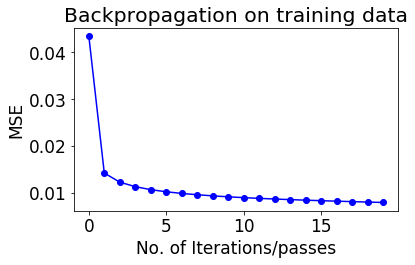

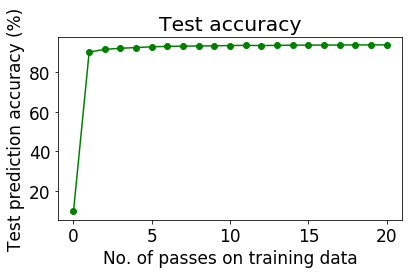

In [20]:
plt.rcParams.update({'font.size':17})
plt.rcParams.update({'savefig.dpi':600})
plt.plot((np.arange(0,err_cum_arr.size-1,1)).T, err_cum_arr[1:],'o-b')
plt.xlabel('No. of Iterations/passes')
plt.ylabel('MSE')
# plt.xlim([0.5,iterMax+5]);
plt.title('Backpropagation on training data')
plt.tight_layout()
plt.savefig('./train_err_sigmoid.png')
plt.show()
#plt.close()

plt.rcParams.update({'font.size':17})
plt.rcParams.update({'savefig.dpi':600})
plt.plot((np.arange(0,pred_acc_arr.size,1)).T, pred_acc_arr/test_samples*100,'o-g')
plt.xlabel('No. of passes on training data')
plt.ylabel('Test prediction accuracy (%)')
# plt.xlim([0.5,iterMax+5]);
plt.title('Test accuracy')
plt.tight_layout()
plt.savefig('./test_err_sigmoid.png')
plt.show()
#plt.close()

